**Búsquedas semiautomatizadas en Pubmed para la exploración del desarrollo de la inteligencia artificial en la biología de 2000 a 2025**

Instalar librerías.

In [2]:
!pip install biopython pandas wordcloud matplotlib numpy seaborn
#simplejson, es opcional si requerimos examinar los metadatos en XML

  Using cached biopython-1.85-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.0 MB/s eta 0:00:00


Se agregan las librerías necesarias.
Se importa la paquetería necesaria para el procesamiento, análisis de texto, visualización y conexión con la API de PubMed.

In [ ]:
from Bio import Entrez
import pandas as pd
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import re
#import json si es necesario

**Definición de términos de búsqueda**: Se anota un correo electrónico para el uso de la API y se crean listas con los términos relacionados con la inteligencia artificial y campos de la biología. Estos fueron agrupados en el diccionario "dict_terms" para facilitar su búsqueda.

Fuentes:

(1) Donthu 2021 *

In [ ]:
Entrez.email = "nruiz@ifc.unam.mx"

ai_field = ["Artificial Intelligence", "Machine learning", "Deep learning"]
biofield = ["Biology", "Biomedicine", "Bioinformatics", "Genetics", "Ecology"]

dict_terms = {}
for i in biofield:
    dict_terms[i] = ai_field

print(dict_terms)

{'Biology': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Biomedicine': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Bioinformatics': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Genetics': ['Artificial Intelligence', 'Machine learning', 'Deep learning'], 'Ecology': ['Artificial Intelligence', 'Machine learning', 'Deep learning']}


**Función 1: Búsqueda en PubMed**. Se limita los resultados a artículos publicados entre los años 2000-2025, así como el número de archivos recolectados "max_res=500" y devuelve una lista de identificadores (PMIDs).

Fuentes:

(1) Dennstädt et al. 2024

(2) https://stackoverflow.com/questions/75933779/biopython-how-can-i-increase-the-number-of-articles-found-using-entrez-esearch

In [ ]:
#Realiza búsquedas en PubMed por combinación de términos de IA +  biología encontrados en el título y resumen
def pubmed_data(terms, start_year="2000", end_year="2025", max_res=500):
  sugg = f""""{terms[0]}"[Title/Abstract] AND "{terms[1]}"[Title/Abstract] AND ({start_year}:{end_year}[dp])"""
  handle = Entrez.esearch(db="pubmed", term=sugg, retmax=max_res)
  results = Entrez.read(handle)
  handle.close()
  return results.get("IdList",[])

**Función 2: Extracción de metadatos** Al recolectar la lista de PMIDs, se recuperan los metadatos de cada artículo desde PubMed en formato XML. El resultado se concatena en un DataFrame estructurado.

Fuente:

(1) https://github.com/TLDWTutorials/PubmedAPI/tree/main

In [ ]:
def details_rec(id_list, ai_term, bio_term):
    df = pd.DataFrame(columns=['PMID', 'Title', 'Abstract', 'Year', 'MeSH_Keywords', 'URL', 'Term_List','Bio_Term'])

     #XML completo
        #print(json.dumps(docs, indent=4, default=str))

    for pmid in id_list:
        try:
            handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml")
            docs = Entrez.read(handle)
            handle.close()

            for doc in docs['PubmedArticle']:
                paper = doc['MedlineCitation']['Article']

                title = paper['ArticleTitle']
                abstract = ' '.join(paper['Abstract']['AbstractText']) if 'Abstract' in paper and 'AbstractText' in paper['Abstract'] else 'Abstract not available'
                year = paper['Journal']['JournalIssue']['PubDate'].get('Year', 'No year found')
                #Palabras clave indexadas con MeSH
                keywords = ', '.join(keyword['DescriptorName'] for keyword in doc['MedlineCitation'].get ('MeshHeadingList', [])) or 'Keyword not found'

                url = f"https://www.ncbi.nlm.nih.gov/pubmed/{pmid}"

                pubmed_df=pd.DataFrame({
                    'PMID':[pmid],
                    'Title':[title],
                    'Abstract':[abstract],
                    'Year':[year],
                    'MeSH_Keywords': [keywords],
                    'URL': [url],
                    'Term_List': [ai_term],
                    'Bio_Term':[bio_term]})

                df = pd.concat([df,pubmed_df], ignore_index=True)

        except Exception as e:
            print(f"PMID error {pmid}: {e}")
            continue

        time.sleep(2)

    return df


**Recolección de datos**:
Se realiza una iteración de los metadatos recolectados junto con los términos de búsqueda en el diccionario "dict_terms" para poder procesar cada combinación.
Los resultados se guardan en una lista vacía y se concatenan en un único DataFrame global "all_results_df" en un formato ya estructurado

Fuentes:

(1) https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

(2) Zhu y Liu 2020 *

(3)Schotten, Plume 2020 *

In [ ]:
all_results_df = []
for bioterm, termlist in dict_terms.items():
  for ai_term in termlist:
    id_list = pubmed_data([bioterm, ai_term], start_year="2000", end_year="2025")
    time.sleep(2)
    #Con la función "details_rec", toma la lista de PMIDs, los términos de IA y de biología...
    df_result = details_rec(id_list, ai_term, bioterm)
    all_results_df.append(df_result)

if all_results_df:
    #Se verifica si hay resultados existentes. Si los hay, se agregan al nuevo dataframe
    all_results_df = pd.concat(all_results_df, ignore_index=True)
    print(all_results_df)

    #Este paso es para revisar el número total de PMIDs encontrados de todas las combinaciones
pmid_count = len(all_results_df)

print(f"\nPMID found: {pmid_count}")

KeyboardInterrupt: 

*Extra*

**Almacenamiento de resultados**: El Dataframe se guarda en formato ".csv"

In [ ]:
#Se almacena y se vuelve a leer el dataframe con los datos en crudo
all_results_df.to_csv('all_results_raw_150525.csv', index=False)
all_results_raw_df_150525 = pd.read_csv('all_results_raw_150525.csv')

**Eliminación de duplicados**: La versión sin PMIDs duplicados, se guarda de nuevo como un archivo ".csv"

In [ ]:
df_clean_150525 = all_results_raw_df_150525.drop_duplicates(subset=['PMID'])
df_clean_150525.to_csv('df_clean_150525.csv', index=False)
df_clean = pd.read_csv('df_clean_150525.csv')

**Agrupación de términos clave para la nube de palabras**:
Se toman dos fuentes distintas para obtener las palabras clave, desde MeSH y desde el título y resúmen de los archivos.

Fuentes:

(1) Natukunda y Muchene (2023) *

(2) https://stackoverflow.com/questions/11858472/string-concatenation-of-two-pandas-columns

(3)https://www.w3schools.com/python/python_regex.asp

(4) https://docs.python.org/3/library/re.html

(5) Westergaard 2018 *

In [ ]:
#Se crea una nueva columna en el dF "df_clean" y se combinan los campos de títulos y resumen de los artículos
df_clean['text_paper'] = df_clean['Title'] + ' ' + df_clean['Abstract']

#Lista vacía para palabras clave de MeSH
mesh_kw = []
for keywords in df_clean['MeSH_Keywords']:
  if keywords != 'Keyword not found':
    words = [word.strip().lower() for word in keywords.split(',')]
    mesh_kw.extend(words)

stopwords=(["4", "two", "2","mi", "mrow","many", "3", "may", "best", "one", "well", "three", "will", "0", "1", "S","s","large","foundanimal", "founddeep","synthetickeyword","processingkeyword","learningkeyword", "personnelkeyword","foundkeyword","intelligencekeyword","proliferationkeyword", "foundhumans", "available", "keywords", "found","no", "not", "keyword"]) + list(STOPWORDS)

##Lista vacía para almacenar las palabras clave de Títle/Abstract "TiAB"
TiAb_kw = []
for text_p in df_clean['text_paper']:
  #Las palabras que se obtengan estarán en minúsculas y se eliminarán signos de puntuación
  text_p = text_p.lower()
  text_p = re.sub(r'[^\w\s]', ' ', text_p)
  words = text_p.split()
  words = [word for word in words if word and word not in stopwords]
  TiAb_kw.extend(words)

# Se combinan ambas listas de palabras clave
all_kwlist = mesh_kw +  TiAb_kw

**Conteo de frecuencia de palabras clave**

Fuente:

(1) https://www.geeksforgeeks.org/python-most_common-function/

In [ ]:
#Se contean las palabras claves existentes en "all_kwlist"
kw_counter = Counter(all_kwlist)

#De todas las palabras clave, se tomarán sólo 77 palabras que más se repiten
frequent_kw = kw_counter.most_common(77)
print("\nFrequent keywords:")
for keyword, frequency in frequent_kw:
  print(f"{keyword}: {frequency}")


Frequent keywords:
learning: 7140
data: 6358
based: 4205
machine: 3977
analysis: 3925
model: 3755
using: 3513
models: 3512
genes: 3069
deep: 2955
research: 2649
study: 2648
methods: 2641
protein: 2592
cell: 2586
ai: 2567
potential: 2458
disease: 2321
prediction: 2311
gene: 2305
cancer: 2213
artificial: 2169
clinical: 2144
genetic: 2118
intelligence: 2068
humans: 2054
high: 2023
used: 1981
molecular: 1784
development: 1713
biology: 1690
related: 1676
expression: 1675
network: 1674
new: 1617
algorithms: 1612
drug: 1592
accuracy: 1568
approaches: 1527
approach: 1519
bioinformatics: 1502
including: 1501
biomarkers: 1487
results: 1487
patients: 1446
identified: 1437
human: 1427
review: 1424
associated: 1405
biological: 1397
immune: 1384
information: 1336
performance: 1334
novel: 1332
studies: 1315
treatment: 1296
risk: 1283
features: 1266
identify: 1262
applications: 1252
use: 1235
datasets: 1229
key: 1221
computational: 1215
cells: 1214
method: 1199
understanding: 1193
significant: 1180
d

**Gráfica 1**: Frecuencia de palabras clave encontradas en MeSH y Title/abstract

Fuentes:

(1) https://stackoverflow.com/questions/11371204/unpack-the-first-two-elements-in-list-tuple

(2) Chen 2017 *

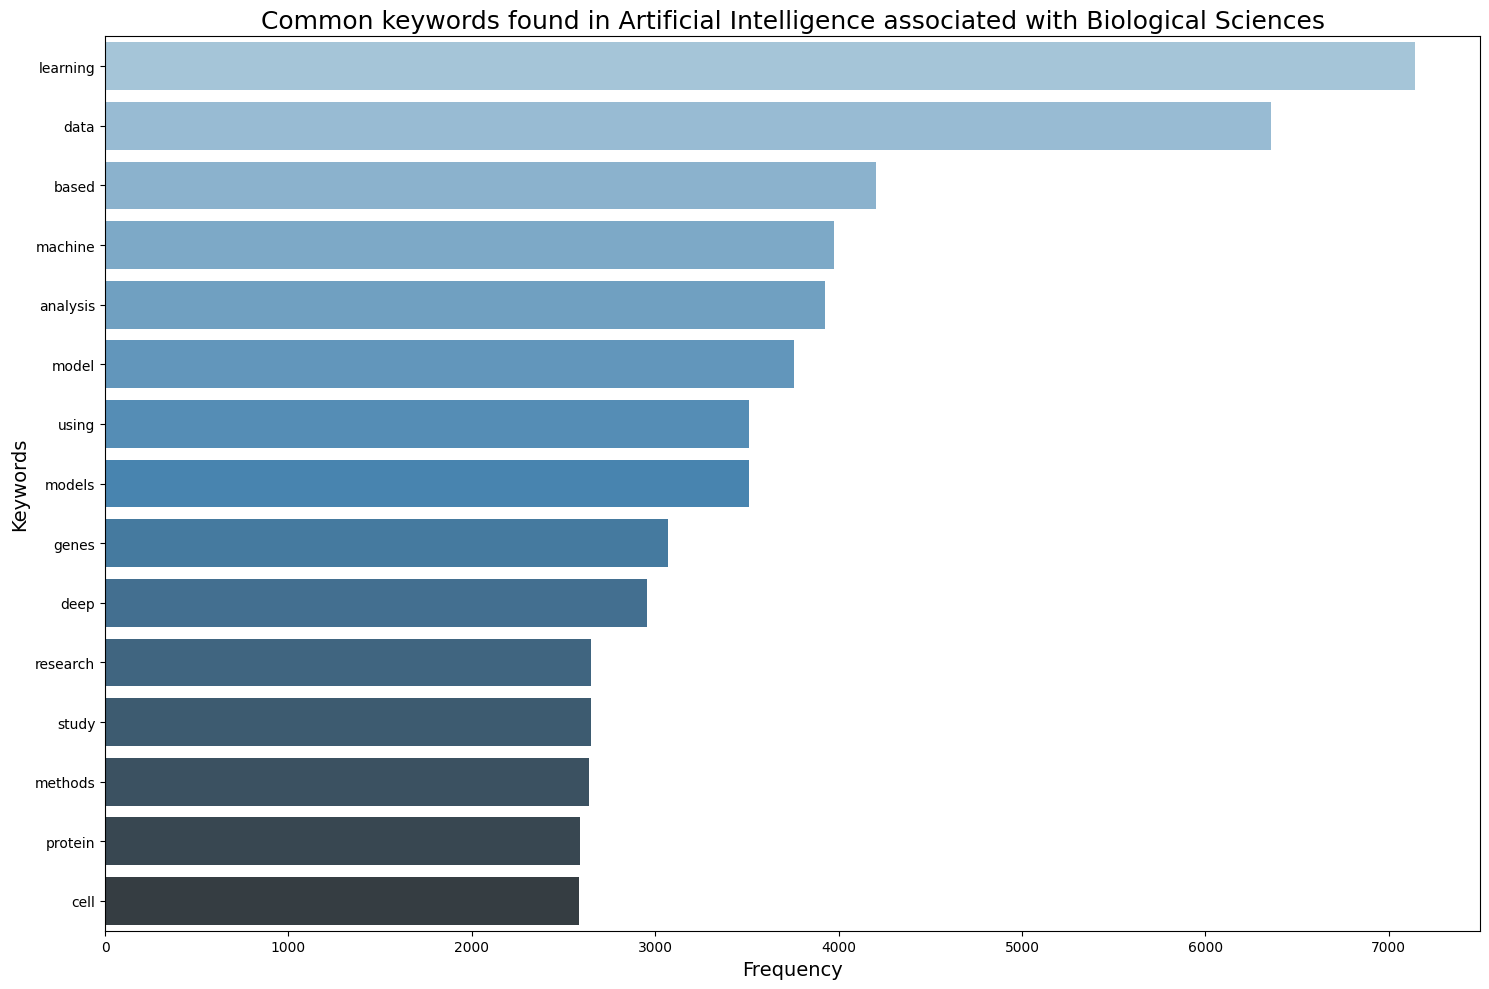

In [ ]:
plt.figure(figsize=(15, 10))
#Se seleccionan 15 palabras más frecuentes para poderlas graficar junto con su frecuencia
keywords = [keyword for keyword, _ in frequent_kw[:15]]
frequencies = [frequency for _, frequency in frequent_kw[:15]]

sns.barplot(x=frequencies, y=keywords, palette='Blues_d', hue=keywords, legend=False)
plt.title('Common keywords found in Artificial Intelligence associated with Biological Sciences', fontsize=18, y=1.00)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Keywords', fontsize=14)
plt.tight_layout()
plt.savefig('common_keywords.png', dpi=300)

plt.show()

Se crea un diccionario para generar la nube de palabras con las palabras clave más frecuentes, ya que "frequent_kw" se encuentra como tupla, siendo que la librería de wordcloud no interpreta esta estructura

In [ ]:
kw_dict = dict(frequent_kw)

**Gráfica 2. Nube de palabras**: Basada en la frecuencia de los términos encontrados en los artículos.

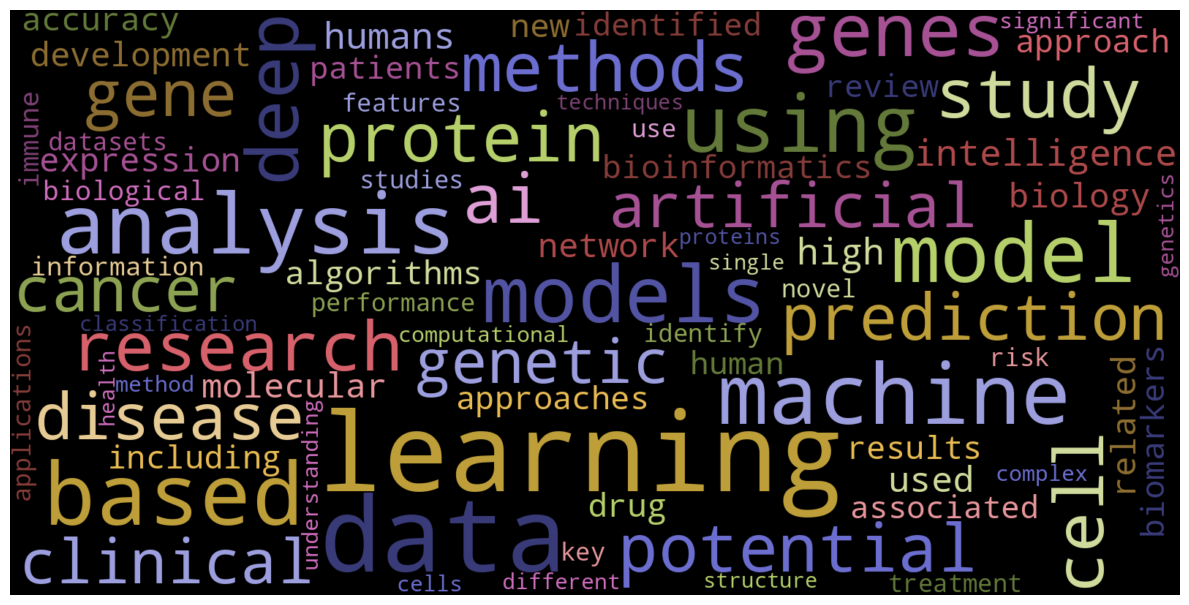

In [ ]:
wordcloud_freq = WordCloud(max_words=100, stopwords=stopwords, width=1600, height=800, background_color="black", max_font_size=150, collocations=True).generate_from_frequencies(kw_dict)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_freq.recolor(colormap='tab20b'),interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=1.08)
plt.savefig('wordcloud_freq.png', dpi=300)
plt.show()

**Preparación de datos**: Se transforman los años a númerico para que los datos puedan ser graficados. Posteriormente se verifica la distribución de los artículos recopilados por año.

Fuentes:

(1) https://stackoverflow.com/questions/61815267/how-do-i-transform-a-pandas-groupby-with-a-condition-on-the-transformation

(2) https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/

In [ ]:
#La columna de "Year" se convierte a númerico para posteriormente sean filtrados entre 2000 y 2025
df_clean['Year']=pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean = df_clean[(df_clean['Year'] >= 2000) & (df_clean['Year'] <= 2025)]

#Este paso es para examinar la distribución de los artículos por año
year_distribution=df_clean.groupby(["Year"]).size()
print("Distribution:")
print(year_distribution)

#En un nuevo dataframe donde agrupan los datos como los términos de búsqueda de la IA y de biología. Y se cuentan cuántos términos existen.
df_clean['Term_List']=df_clean['Term_List'].astype(str)
df_bar = df_clean.groupby(['Bio_Term', 'Term_List']).size().reset_index(name='Count')

print(df_clean)

Distribution:
Year
2004.0       3
2006.0       3
2007.0       3
2008.0       3
2009.0       7
2010.0       7
2011.0       8
2012.0       5
2013.0       7
2014.0       9
2015.0      16
2016.0      24
2017.0      27
2018.0      55
2019.0     101
2020.0     137
2021.0     256
2022.0     438
2023.0     702
2024.0    1436
2025.0    1411
dtype: int64
          PMID                                              Title  \
0     40366503  Research on the developments of artificial int...   
1     40364863  In Silico Research Is Rewriting the Rules of D...   
2     40364668     Shining a Light on the Future of Biophotonics.   
3     40364189  Beyond Size: Advanced MRI Breakthroughs in Pre...   
4     40361907  From Morphology to Gene Expression Profiling i...   
...        ...                                                ...   
4655  33466513  Mask R-CNN and OBIA Fusion Improves the Segmen...   
4656  32620873  A new method to control error rates in automat...   
4657  31970895  Neural hierarchi

<ipython-input-20-ba7e54b4386f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Term_List']=df_clean['Term_List'].astype(str)


**Gráfica 3. Conteo de publicaciones**: Se genera una gráfica de barras que muestran el número de publicaciones encontradas en los términos encontrados en el campo biológico y el área de la IA

Fuentes:

(1) https://python-graph-gallery.com/basic-barplot-with-seaborn/

(2) https://www.delftstack.com/es/howto/python-pandas/pandas-column-contains-string/?utm_source=chatgpt.com

(3) https://github.com/modin-project/modin/issues/847

(4) https://www.kaggle.com/code/valeriamulina/bank-customers-categorization-clustering?scriptVersionId=139180478

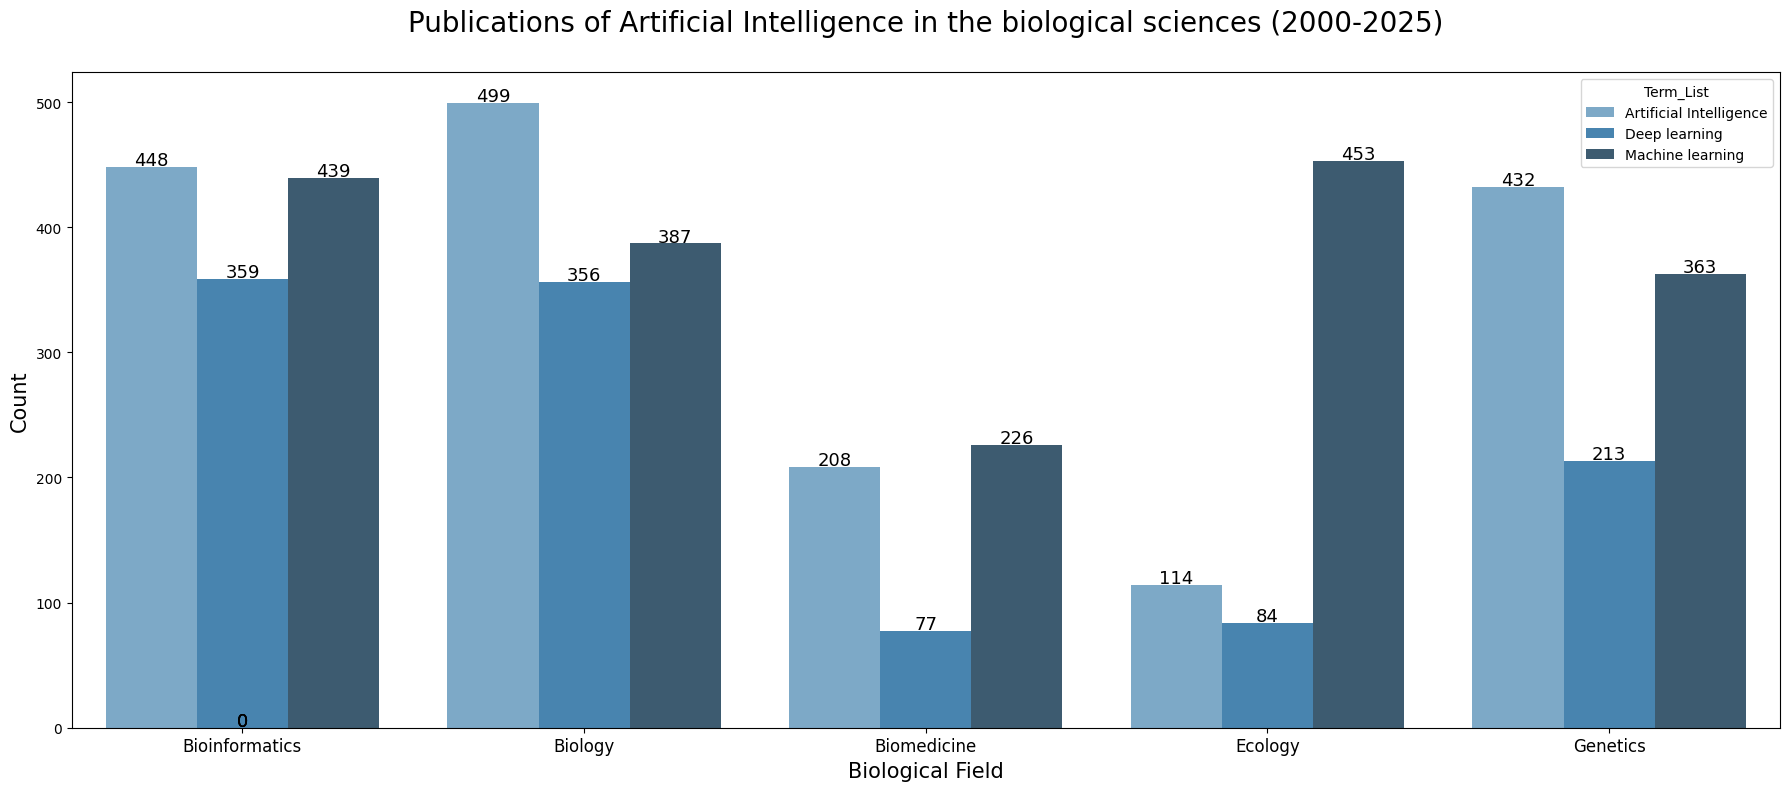

In [ ]:
plt.figure(figsize=(18, 8))
#Para la gráfia de barras, en el eje "x", se agregan los campos biológicos y en el eje "y", se agrega el conteo.
ax=sns.barplot(x='Bio_Term', y='Count', hue='Term_List', data=df_bar, palette='Blues_d')

plt.title('Publications of Artificial Intelligence in the biological sciences (2000-2025)', fontsize=20, y= 1.05)
plt.xlabel('Biological Field', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=0, fontsize=12)

#Se anotan los valores a cada una de las barras
for p in ax.patches:
  ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=13)

plt.tight_layout()
plt.savefig('barplot_count.png', dpi=300)
plt.show()

**Gráfica 4.**: Se genera un "FacetGrid" con los términos de búsqueda para visualizar y comparar la cantidad de publicaciones por año

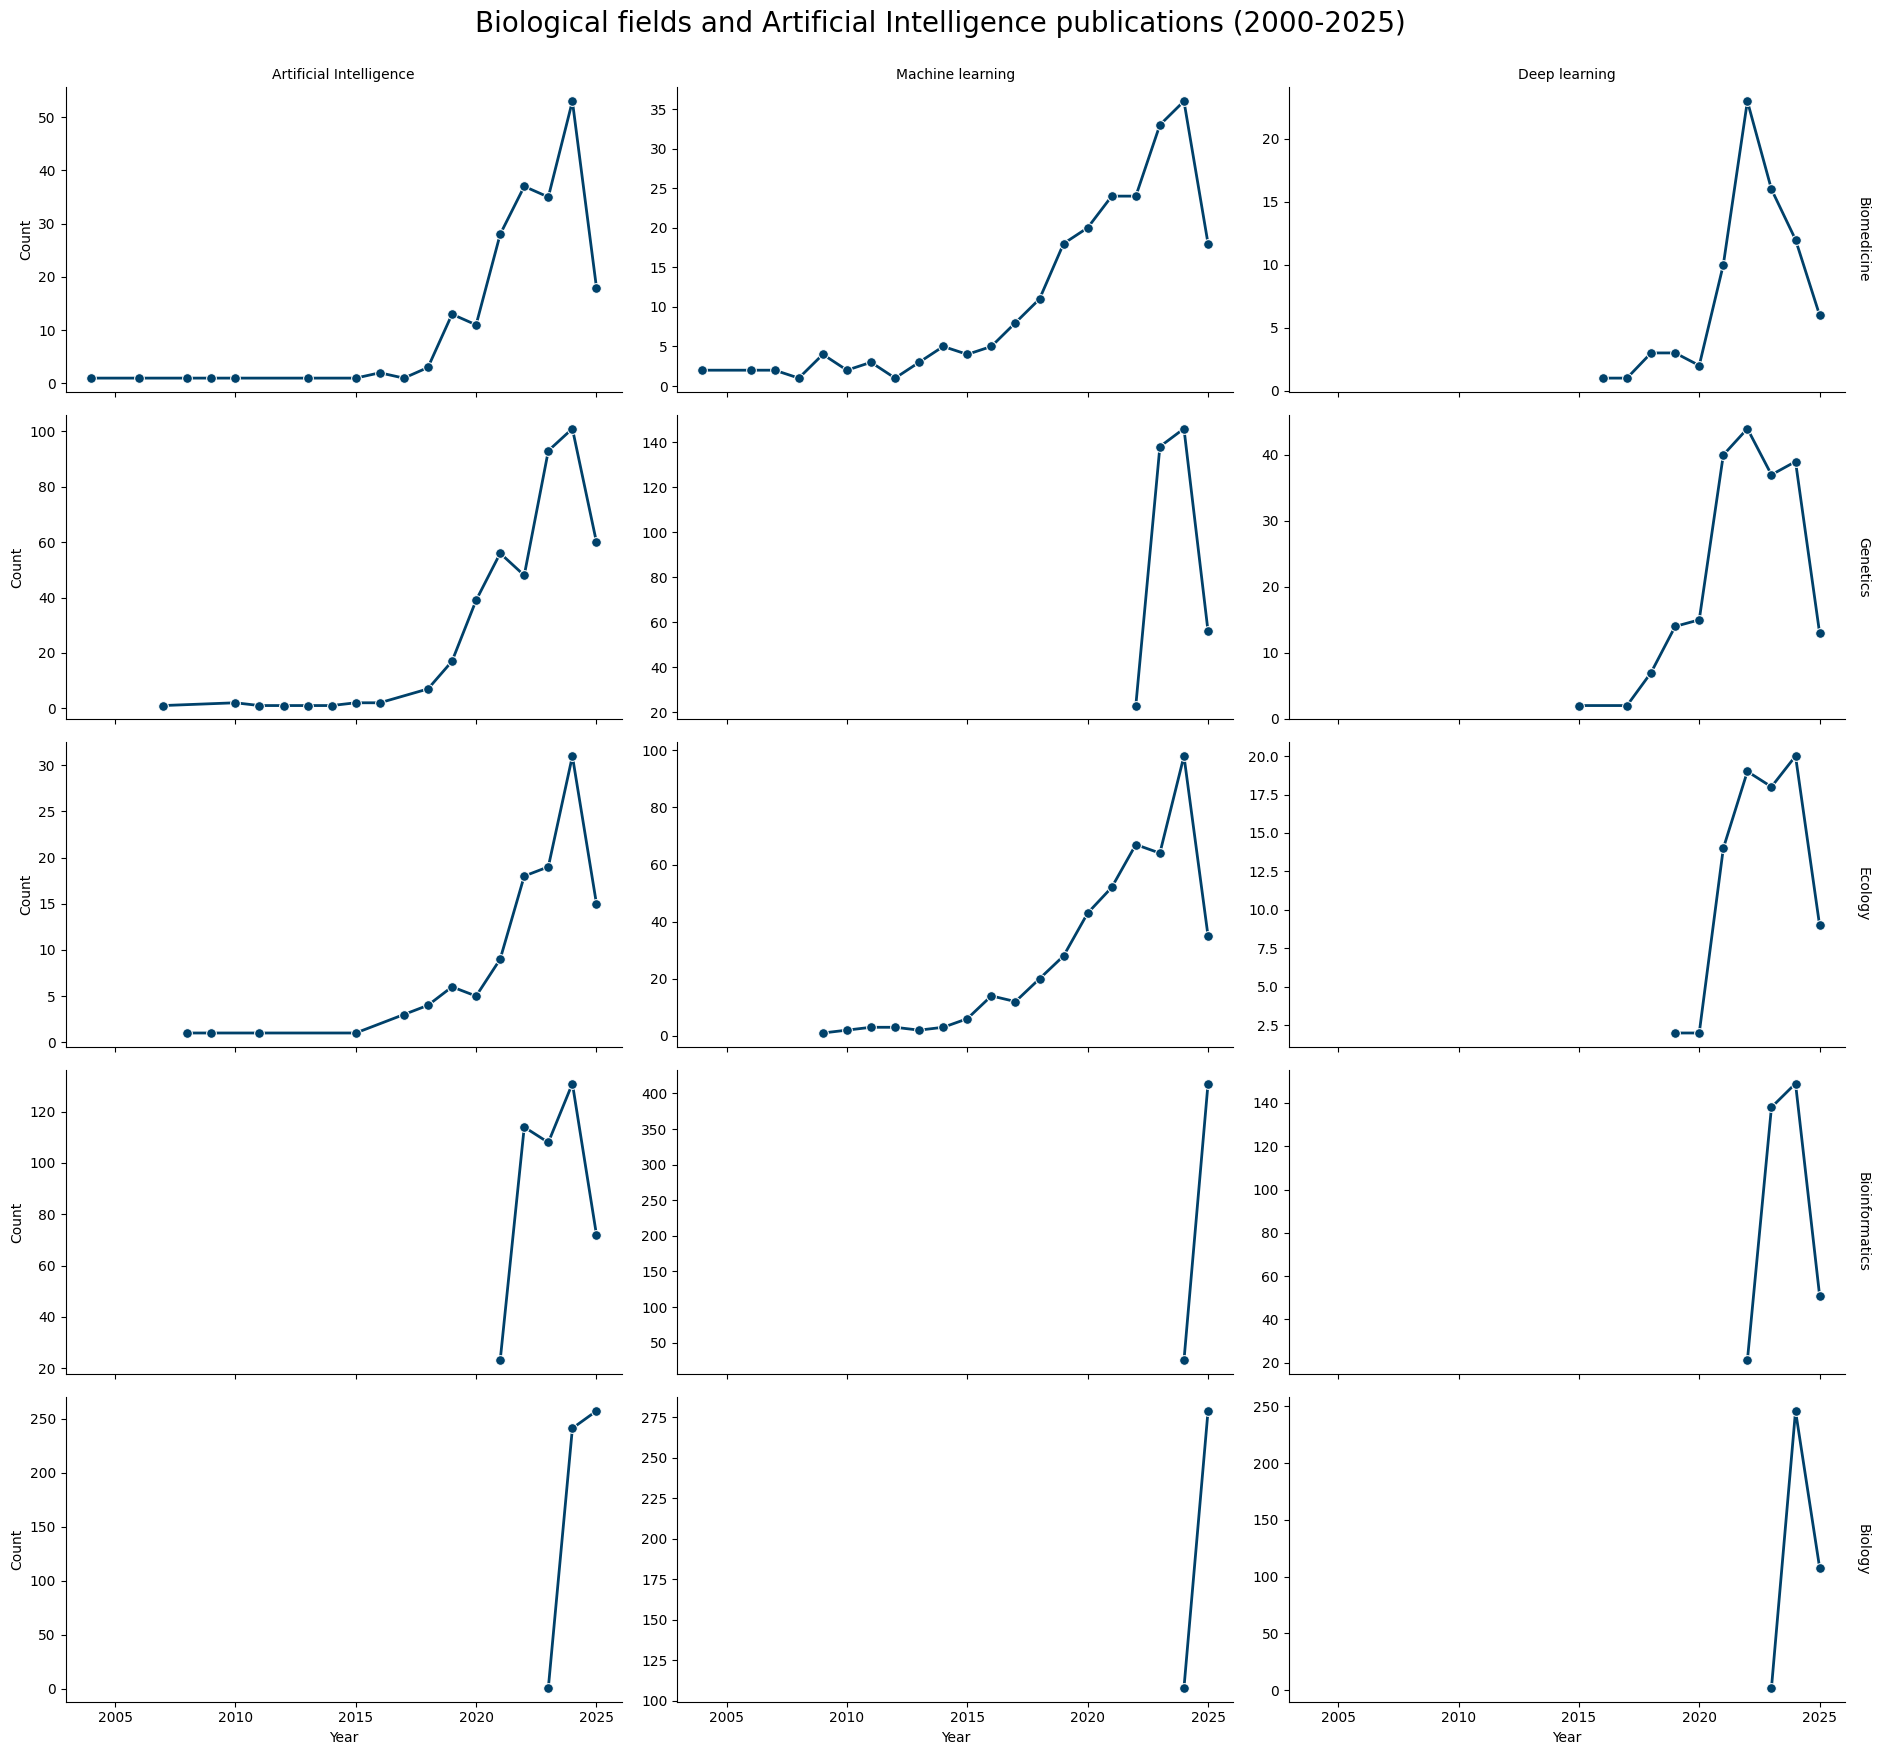

In [ ]:
#Se realiza otro dF, que agrupará el año, el campo biológico y el área de la IA, los cuales serán contados
yearly_counts = df_clean.groupby(['Year', 'Bio_Term', 'Term_List']).size().reset_index(name='Count')

#sns.set_theme(style="darkgrid")

g=sns.FacetGrid(yearly_counts, col="Term_List", row="Bio_Term", margin_titles=True, height=3.5, aspect=1.8, sharey=False)
g.map_dataframe(sns.lineplot, x="Year", y="Count", marker='o', markersize=7, linewidth=2, color="#00416A")
#Para eliminar corchetes y comillas de los subtextos se escribe ".strip("[]'"")"
g.set_titles(col_template="{col_name}".strip("[]'"), row_template="{row_name}")
g.fig.suptitle("Biological fields and Artificial Intelligence publications (2000-2025)", fontsize= 20, y=1.00)

plt.tight_layout()
plt.savefig('facetgrid_count.png', dpi=300)
plt.show()

**Gráfica 5. Tendencia general de los términos del área de la IA**: Se obtiene el número total de publicaciones por año, identificando el crecimiento del uso de la IA en las ciencias biológicas entre los años 2000 a 2025

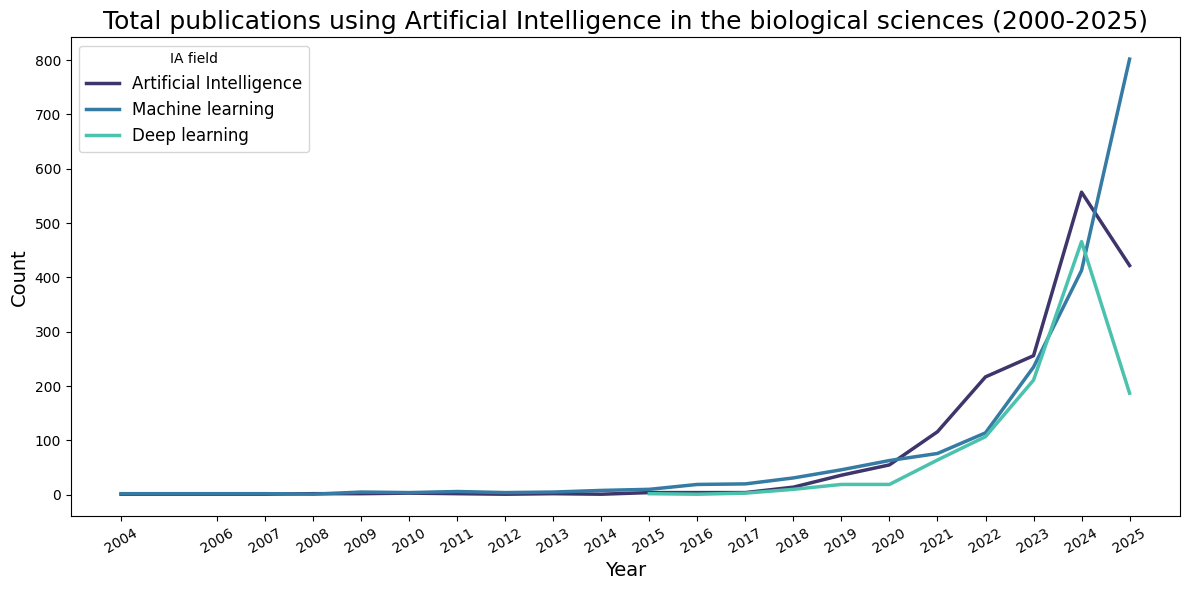

In [ ]:
#En este dF, se toma "yearly_counts" el cuál se vuelve a reagrupar tomando sólo el año y el área de la IA
summary_df = yearly_counts.groupby(['Year', 'Term_List'])['Count'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Count', hue='Term_List', data=summary_df, markers= True, dashes=False, linewidth=2.5, palette='mako')


plt.title("Total publications using Artificial Intelligence in the biological sciences (2000-2025)", fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(sorted(df_clean['Year'].unique()), rotation=30)
plt.legend(title='IA field', fontsize=12)

plt.tight_layout()
plt.savefig("total_pub", dpi=300)
plt.show()

Bibliografía

(1) Dennstädt, F., Zink, J., Putora, P. M., Hastings, J., & Cihoric, N. (2024). Title and abstract screening for literature reviews using large language models: an exploratory study in the biomedical domain. Systematic Reviews, 13(1). https://doi.org/10.1186/s13643-024-02575-4

(2) Donthu 2021, How to conduct a bibliometric analysis: an overview and guidelines

(3) Zhu y Liu 2020. A tale of two databases: the use of web science and scopus

(4) Schotten, Plume 2020. Scopus as curated, high-quality bibliometric data source for academic research

(5) Natukunda, A., & Muchene, L. K. (2023). Unsupervised title and abstract screening for systematic review: a retrospective case-study using topic modelling methodology. Systematic Reviews, 12(1). https://doi.org/10.1186/s13643-022-02163-4

(6) Westergaard 2018. A comprehensive and quantitatve comparison of text-mining in 15 million full-text articles versus

(7) Chen 2017. Science mapping: a systematic review of literature